In [17]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam, lr_scheduler

from utils import get_device, f1_score_function
from sklearn.metrics import accuracy_score

## Analyze dataset

In [18]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [19]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [20]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [21]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

### Test set

In [22]:
texts_df_test = pd.read_csv('subtaskA_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,La CNN ha appena ammesso che Trump non è più a...
1,1,"Notizia del 2017: “Autovelox, la foto viola la..."
2,2,"La foto di due ""sospetti"" in un palazzo non è ..."
3,3,La falsa notizia della bambina con il cartello...
4,4,Ah dimenticavo.. e' gratuita


In [23]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            460 non-null    int64 
 1   comment_text  460 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


## Preprocessing

Remove break line characthers

In [24]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))


## Train-Validation split

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [26]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [27]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [28]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [29]:
from transformers import LlamaTokenizer

In [30]:
tokenizer = LlamaTokenizer.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

In [31]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

texts_test = texts_df_test['comment_text']

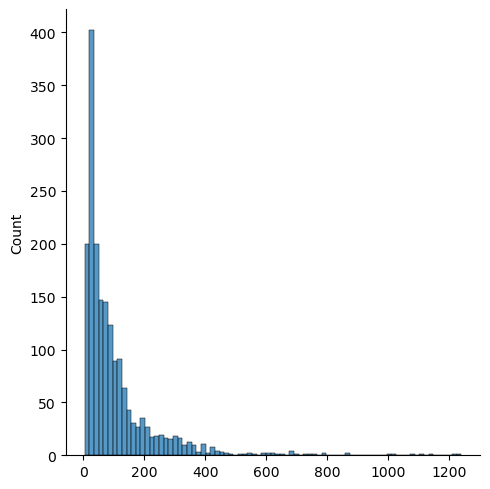

In [32]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

Llama max token length is 2048.

In [17]:
input_ids_tr, input_ids_val, input_ids_test = [], [], []

for sentence in texts_tr:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_tr.append(tokenized)

for sentence in texts_val:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_val.append(tokenized)

for sentence in texts_test:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_test.append(tokenized)

## Llama model

In [18]:
from transformers import LlamaModel

model = LlamaModel.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.49s/it]
Some weights of the model checkpoint at /home/giacomo/Ai/llama/hgf_weights were not used when initializing LlamaModel: ['lm_head.weight']
- This IS expected if you are initializing LlamaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
llama_embeddings_tr, llama_embeddings_val, llama_embeddings_test = [], [], []

llama_embed_folder_pth = 'llama_embeddings'
if not os.path.exists(llama_embed_folder_pth):
    os.makedirs(llama_embed_folder_pth)

Get and save Llama embeddings for traning, validation and test sets.

In [20]:
for input_ids in tqdm(input_ids_tr):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_tr.append(last_hidden_states[0][:, -1, :].numpy())


# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy'), llama_embeddings_tr)

100%|██████████| 1473/1473 [1:45:22<00:00,  4.29s/it]  


In [25]:
for input_ids in tqdm(input_ids_val):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_val.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy'), llama_embeddings_val)

100%|██████████| 369/369 [26:40<00:00,  4.34s/it] 


In [26]:
for input_ids in tqdm(input_ids_test):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_test.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy'), llama_embeddings_test)

100%|██████████| 460/460 [38:56<00:00,  5.08s/it] 


# NN classifier on Llama embeddings

### Generate Dataloaders

In [40]:
labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

/tmp/ipykernel_4730/211815609.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tr = torch.tensor(labels_tr)
/tmp/ipykernel_4730/211815609.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val = torch.tensor(labels_val)


In [62]:
llama_embeddings_tr = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy'))))
llama_embeddings_val = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy'))))
llama_embeddings_test = torch.tensor(np.squeeze(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy'))))

In [63]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [65]:
print(llama_embeddings_test.size())

torch.Size([460, 4096])


Wrap data into a TensorDataset

In [66]:
tr_dataset = TensorDataset(llama_embeddings_tr, labels_tr)
val_dataset = TensorDataset(llama_embeddings_val, labels_val)
test_dataset = TensorDataset(llama_embeddings_test)

Create DataLoaders

In [45]:
batch_size = 32

tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

### NN Model

Model object and initialization function.

In [46]:
class LllamaEmbedsClf(nn.Module):
    def __init__(self, hidden_layers_dim=[2048, 64], layers_dropout=[0.3, 0.2],  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Check if hidden_layers_dim and dropout_probs have the same length
        if len(hidden_layers_dim) != len(layers_dropout):
            raise ValueError('hidden_layers_dim and dropout_probs must have the same length')

        llama_hidden_dim = 4096

        # Dynamic hidden layers dim and dropput
        self.layers = nn.ModuleList()
        prev_dim = llama_hidden_dim
        for i, hidden_dim in enumerate(hidden_layers_dim):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(layers_dropout[i]))
            prev_dim = hidden_dim

        self.layers.append(nn.Linear(hidden_layers_dim[-1], 2))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
# Returns initialized model
def init_llama_embeds_clf(lr_rate=1e-5, gamma=0.9, hidden_layers_dim=[2048, 64], layers_dropout=[0.3, 0.2]):
    llama_embeds_clf = LllamaEmbedsClf(hidden_layers_dim=hidden_layers_dim, layers_dropout=layers_dropout)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = Adam(params = llama_embeds_clf.parameters(), lr=lr_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
    
    return llama_embeds_clf, loss_function, optimizer, scheduler

Train, validation and test functions whcih include loop over batches (for 1 epoch only).    

In [77]:
def train_clf(model, tr_dataloader, loss_function, optimizer, scheduler, device='cpu'):
    model.to(device)

    # Put the model into training mode
    model.train()

    loss_total = 0
    predictions, labels = [], []

    for step, batch in enumerate(tr_dataloader):
        # Load batch to GPU
        b_embeds = batch[0].to(device)
        b_labels = batch[1].to(device)

        # Zero out any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass
        raw_preds = model(b_embeds)

        loss = loss_function(raw_preds, b_labels)
        loss_total += loss.item()

        # Discretize classes
        _, b_preds = torch.max(raw_preds, dim=1)

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update optimizer and scheduler
        optimizer.step()
        scheduler.step()

        # Move preds and labels to CPU
        b_preds = b_preds.detach().cpu().tolist()
        b_labels = b_labels.detach().cpu().tolist()
        
        # Store predictions and true labels
        predictions += b_preds
        labels += b_labels

    # Calculate scores and avg loss
    acc_score = accuracy_score(labels, predictions)
    f1_score = f1_score_function(labels, predictions)
    avg_epoch_loss_tr = loss_total / len(tr_dataloader)  

    return avg_epoch_loss_tr, acc_score, f1_score, model, optimizer, scheduler

def eval_clf(model, eval_dataloader, loss_function, device='cpu'):
    # Put model into evaluation mode
    model.eval()

    loss_total = 0
    predictions, labels = [], []

    with torch.no_grad():
        for step, batch in enumerate(eval_dataloader):
            b_embeds, b_labels = tuple(t.to(device) for t in batch)
            
            # Perform a forward pass
            raw_preds = model(b_embeds)

            loss = loss_function(raw_preds, b_labels)
            loss_total += loss.item()
            
            # Discretize classes
            _, b_preds = torch.max(raw_preds, dim=1)

            # Move preds and labels to CPU
            b_preds = b_preds.detach().cpu().tolist()
            b_labels = b_labels.detach().cpu().tolist()
            
            # Store predictions and true labels
            predictions += b_preds
            labels += b_labels

    # Calculate scores and avg loss
    acc_score = accuracy_score(labels, predictions)
    f1_score = f1_score_function(labels, predictions)
    avg_epoch_loss_eval = loss_total / len(eval_dataloader)

    return avg_epoch_loss_eval, acc_score, f1_score, predictions, labels

def test_clf(model, test_dataloader, device='cpu'):
    # Put model into evaluation mode
    model.eval()

    predictions, raw = [], []

    with torch.no_grad():
        for step, batch in enumerate(test_dataloader):
            b_embeds = batch[0].to(device)
            
            # Perform a forward pass
            raw_preds = model(b_embeds)

            # Discretize classes
            _, b_preds = torch.max(raw_preds, dim=1)

            # Move preds to CPU
            b_preds = b_preds.detach().cpu().tolist()
            
            # Store predictions
            predictions += b_preds

    return predictions

### Grid search

Set save folder for this run

In [52]:
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_llama_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-05-01 01:16:38.299099


Define fixed hyperparams.

In [53]:
max_epochs = 20
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


Grid searched hyperparams.

In [54]:
lr_list = [1e-5, 5e-5, 1e-4, 5e-4]
gamma_list = [0.95, 0.99]
# 'layers' indicates each hidden layer's dimension, while 'dropout' indicates the dropout prob after corresponding hiddenlayer
layers_config_list = [
    {'layers': [4096, 128], 'dropout':[0.4, 0.2], 'name': '3_layers_M'},
    {'layers': [4096, 512, 32], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_M'},
    {'layers': [8192, 1024, 64], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_L'}
]

Execute grid search. Loop over epochs for each hyperparam combination.

In [55]:
num_trials = len(lr_list) * len(gamma_list) * len(layers_config_list)
print('Executing {} trials in grid search'.format(num_trials))

for lr in lr_list:
    for gamma in gamma_list:
        for layers_config in layers_config_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_gamma{}_layers_{}'.format(lr, gamma, layers_config['name'])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, gamma={}, layers={}'.format(lr, gamma, layers_config['name']))

            torch.cuda.empty_cache()
            #print(torch.cuda.memory_summary())

            # Initialize model
            llama_embeds_model, loss_function, optimizer, scheduler = init_llama_embeds_clf(
                lr_rate=lr, gamma=gamma, hidden_layers_dim=layers_config['layers'], layers_dropout=layers_config['dropout'])

            for epoch_i in range(max_epochs):
                print('Epoch: {}'.format(epoch_i))

                # Train
                avg_epoch_loss_tr, acc_score_tr, f1_score_tr, llama_embeds_model, optimizer, scheduler = train_clf(llama_embeds_model, tr_dataloader, loss_function, optimizer, scheduler, device)


                print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

                # Eval
                avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(llama_embeds_model, val_dataloader, loss_function, device)
                print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

                # Save
                model_save_pth = os.path.join(model_folder_pth, 'llama_clf_{}.pt'.format(epoch_i))
                torch.save({
                            'epoch': epoch_i,
                            'model_state_dict': llama_embeds_model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'schdeduler_state_dict': scheduler.state_dict(),
                            'tr_loss': avg_epoch_loss_tr,
                            'val_loss': avg_epoch_loss_val,
                            'tr_acc': acc_score_tr,
                            'val_acc': acc_score_val,
                            'tr_f1': f1_score_tr,
                            'val_f1': f1_score_val,
                            'val_preds': predictions
                            }, model_save_pth)

            torch.cuda.empty_cache()

Executing 24 trials in grid search

Executing model with lr=1e-05, gamma=0.95, layers=3_layers_M
Epoch: 0
TRAINING | Tr Loss: 0.6454295477968581 - Tr acc: 0.6191446028513238 - Tr f1: 0.6136285957284455
EVALUATION | Val Loss: 0.6082004954417547 - Val acc: 0.6531165311653117 - Val f1: 0.6381687810259239
Epoch: 1
TRAINING | Tr Loss: 0.6167639728556288 - Tr acc: 0.6442634080108622 - Tr f1: 0.6373762050626727
EVALUATION | Val Loss: 0.6039073963960012 - Val acc: 0.6531165311653117 - Val f1: 0.6389874036932861
Epoch: 2
TRAINING | Tr Loss: 0.6057657238016737 - Tr acc: 0.6680244399185336 - Tr f1: 0.6601656103904927
EVALUATION | Val Loss: 0.6035422285397848 - Val acc: 0.6585365853658537 - Val f1: 0.6454087858450275
Epoch: 3
TRAINING | Tr Loss: 0.6274413948363446 - Tr acc: 0.648336727766463 - Tr f1: 0.6393119161971033
EVALUATION | Val Loss: 0.6035099575916926 - Val acc: 0.6585365853658537 - Val f1: 0.6454087858450275
Epoch: 4
TRAINING | Tr Loss: 0.6086572510130862 - Tr acc: 0.658520027155465 - Tr

## Analyze grid search results

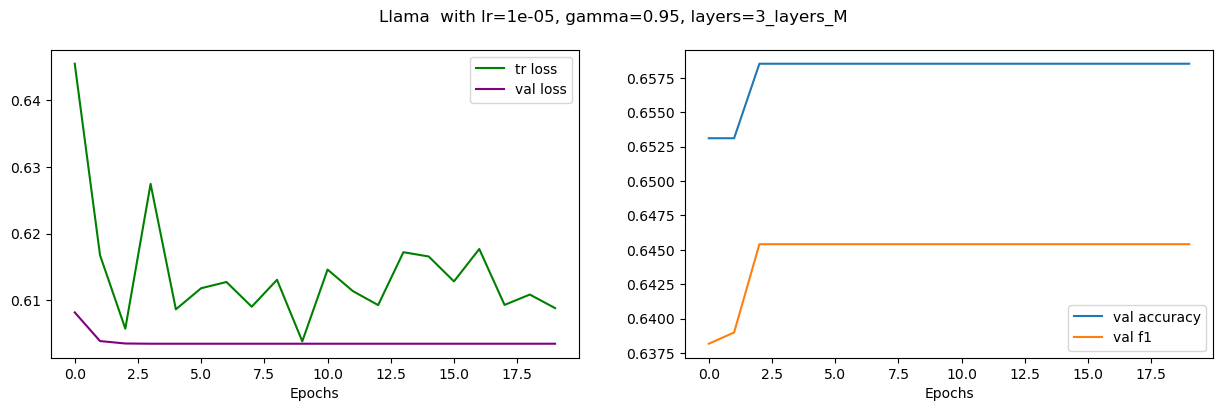

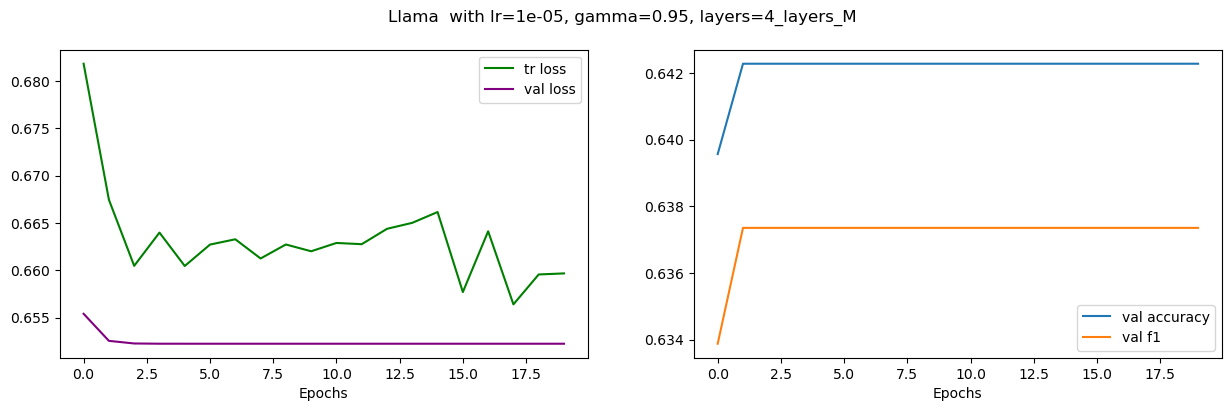

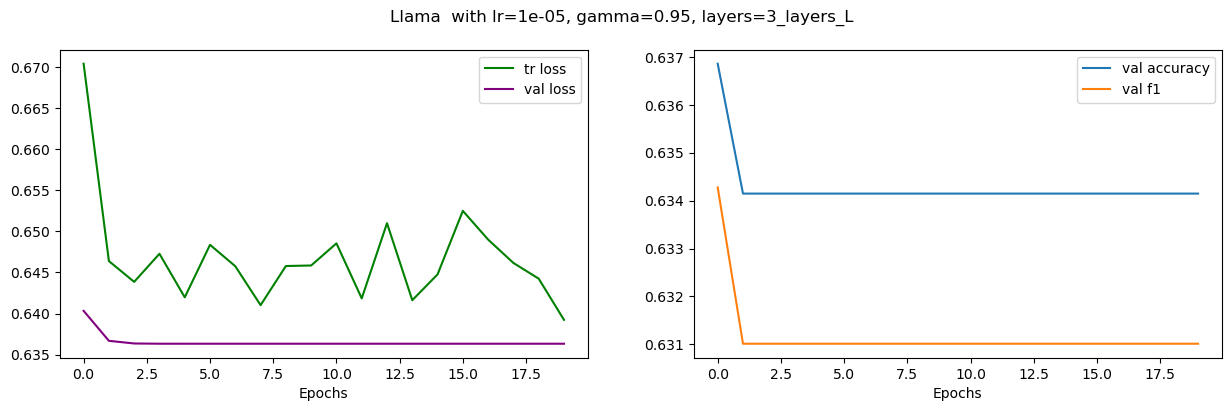

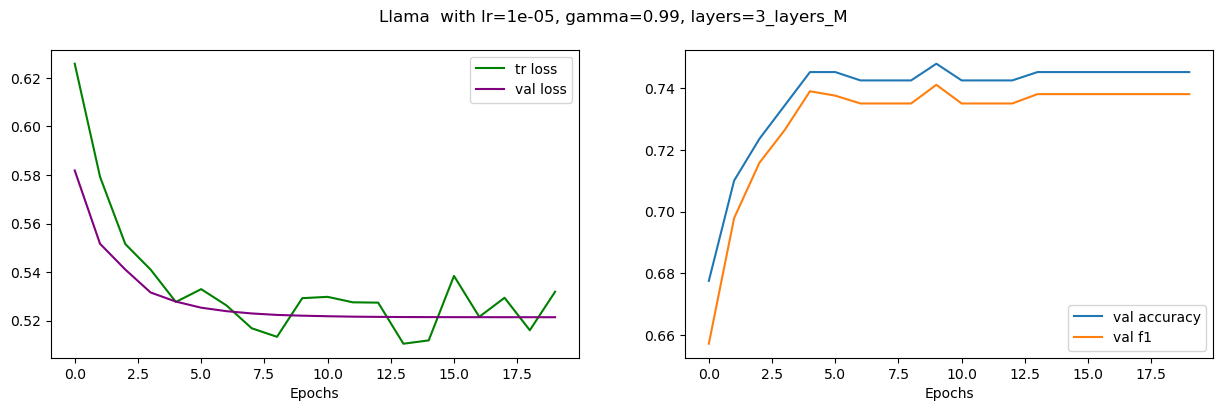

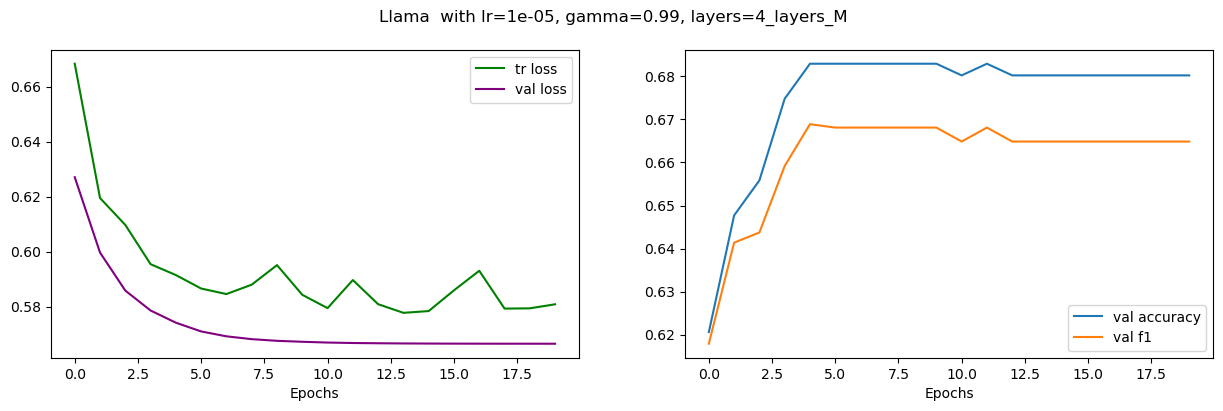

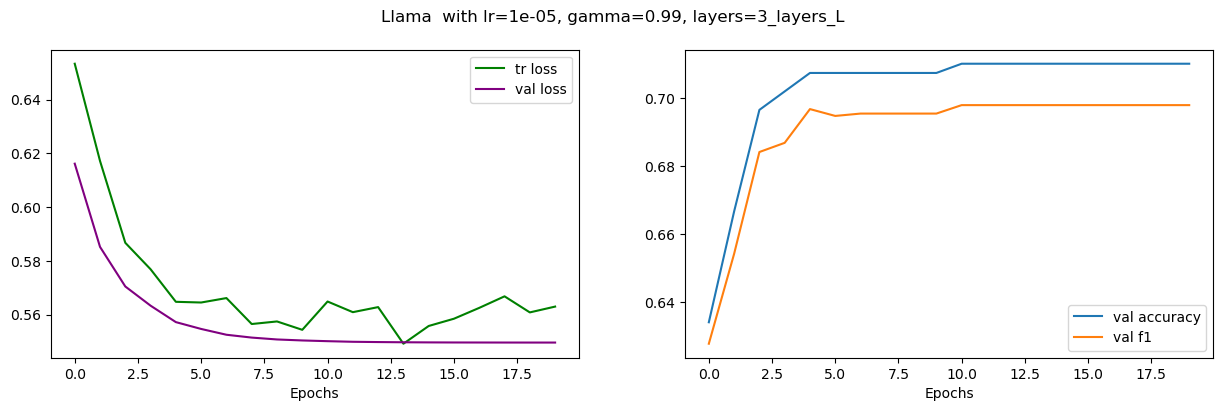

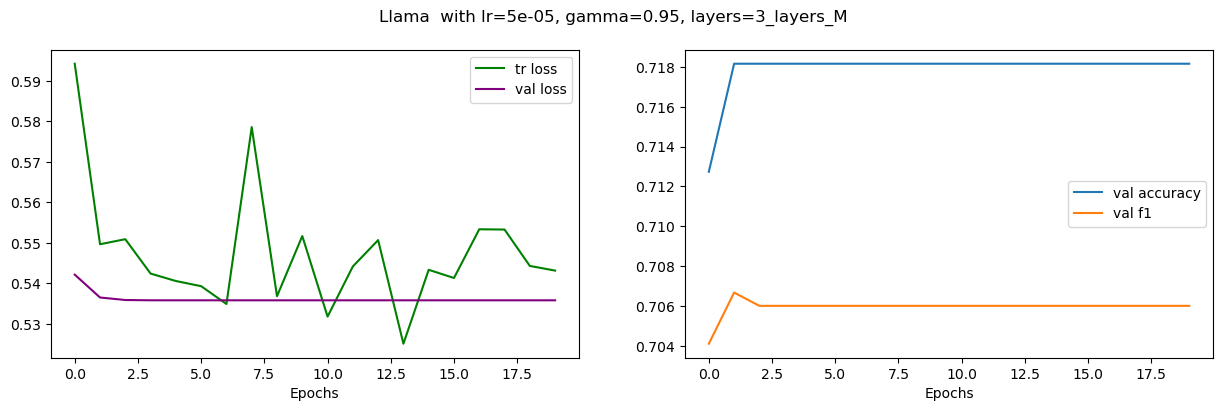

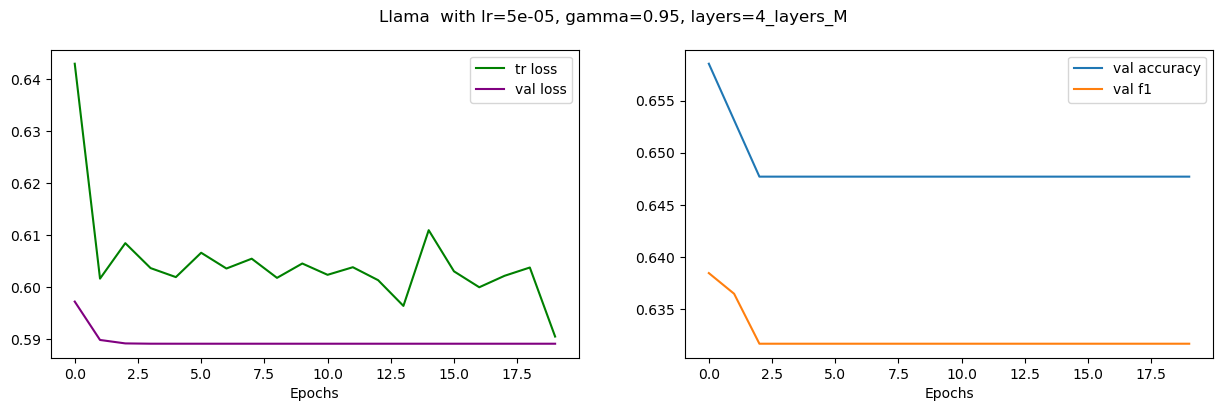

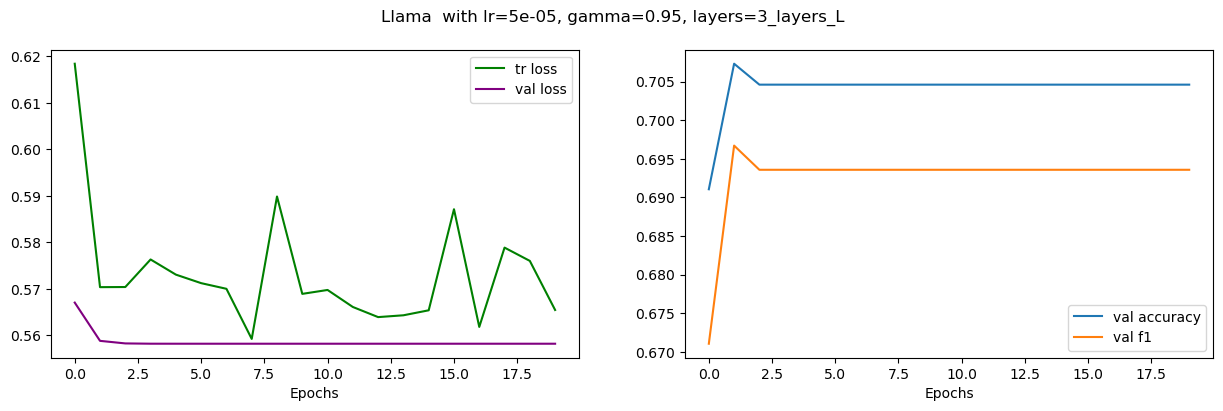

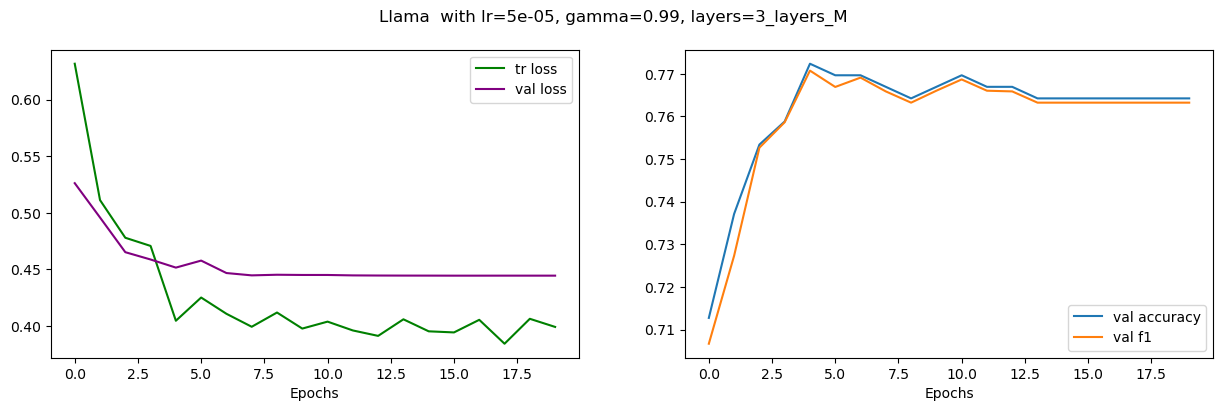

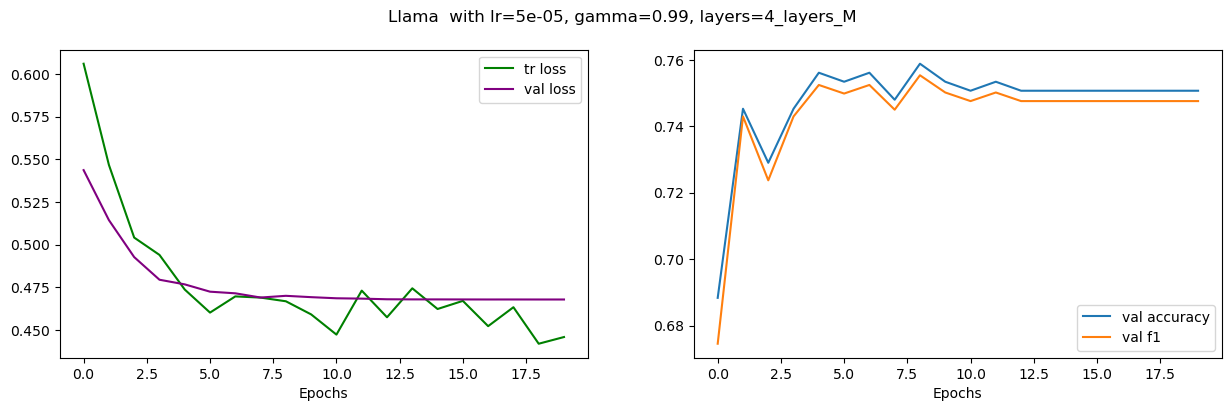

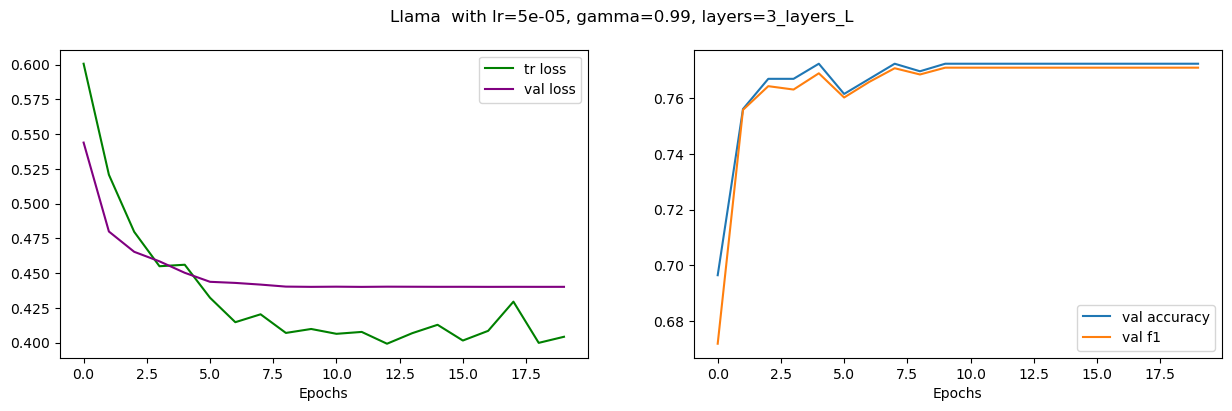

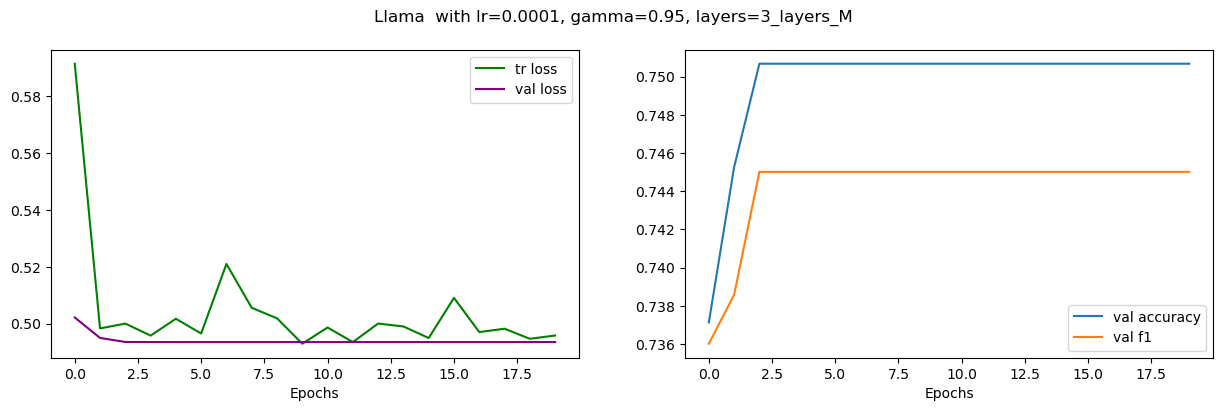

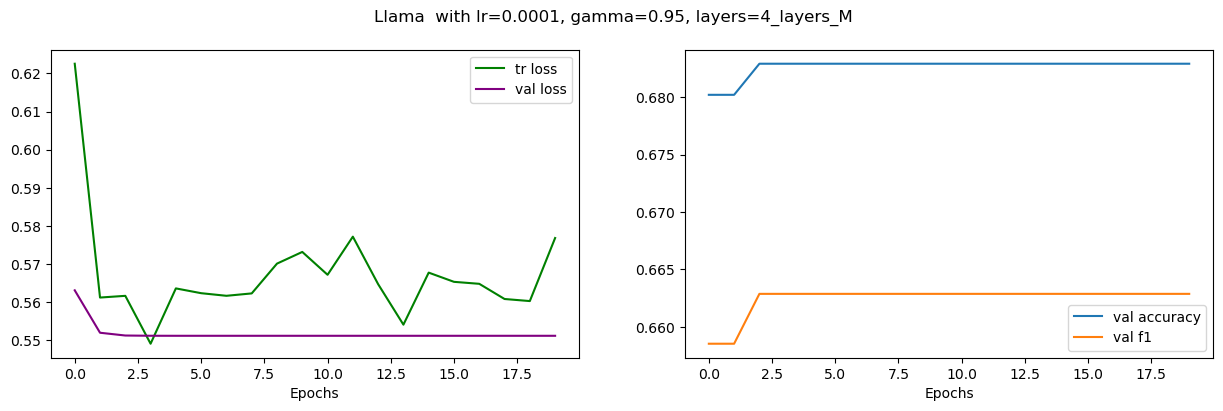

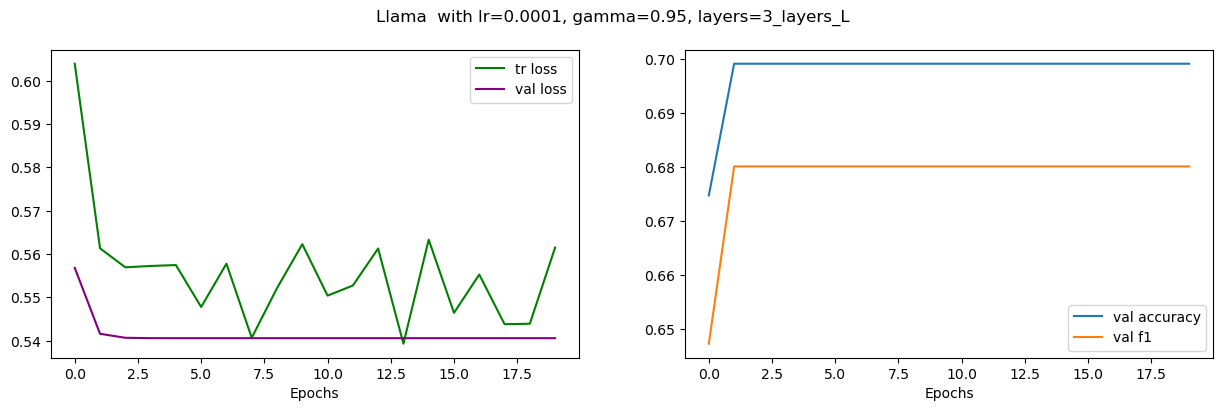

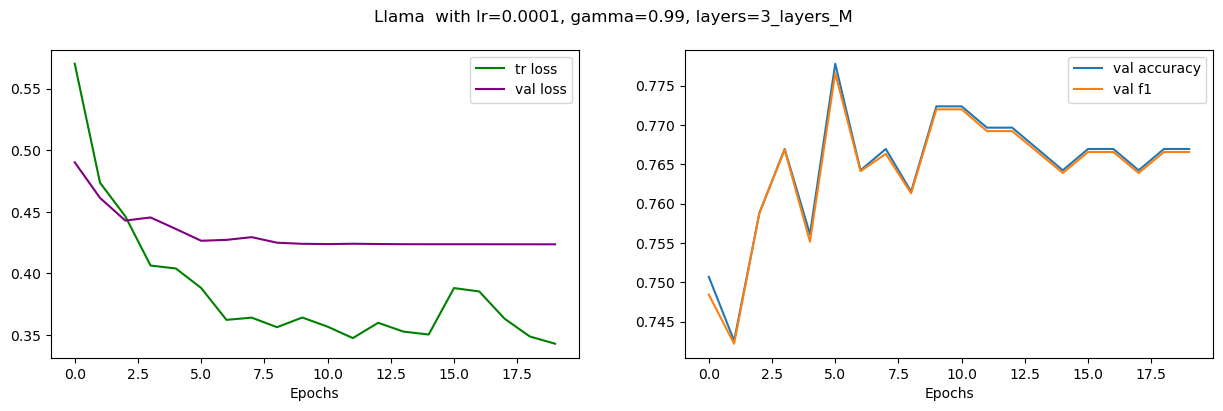

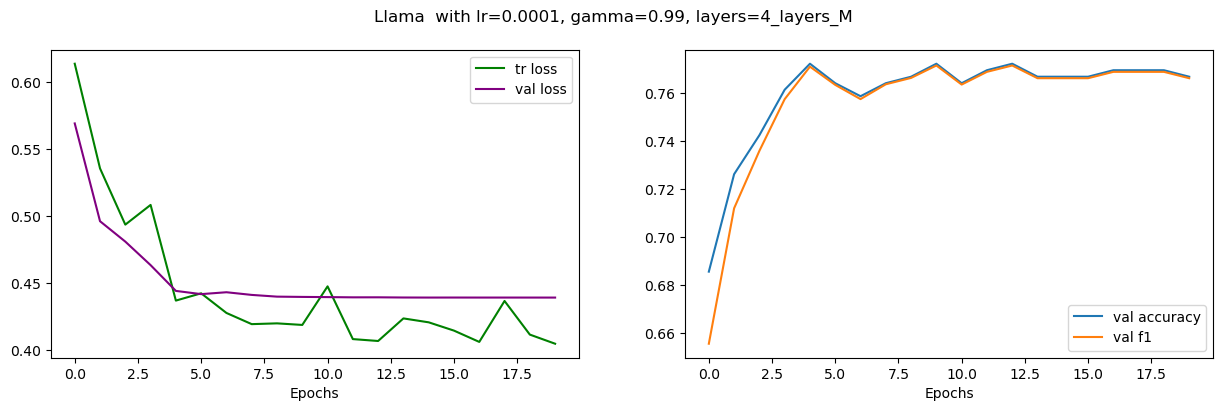

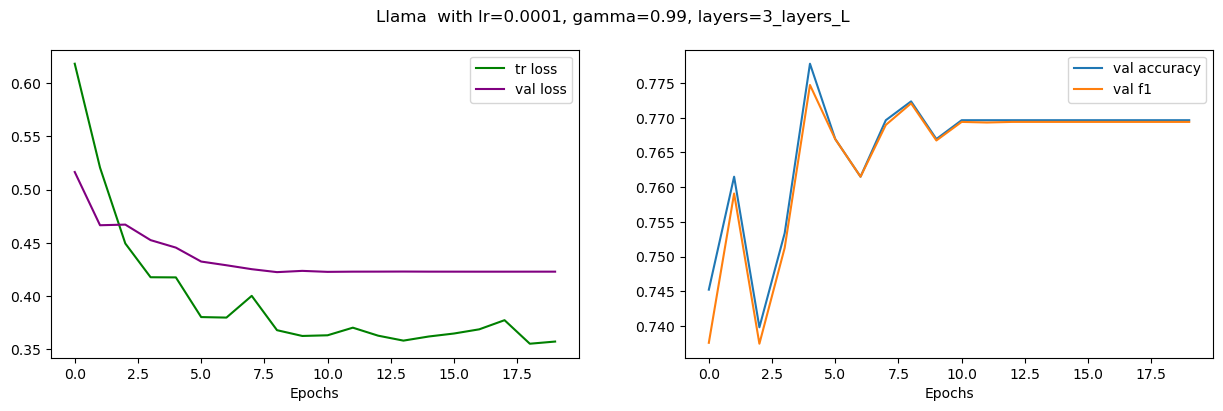

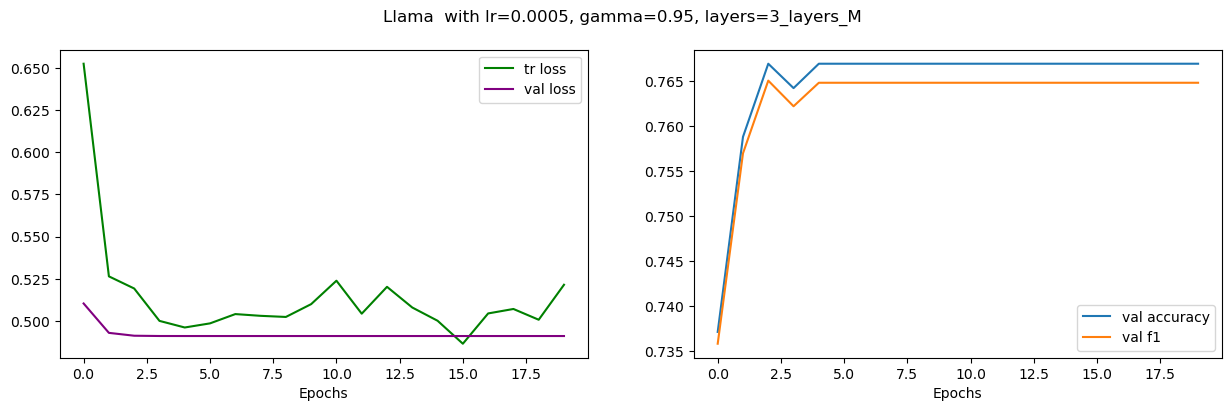

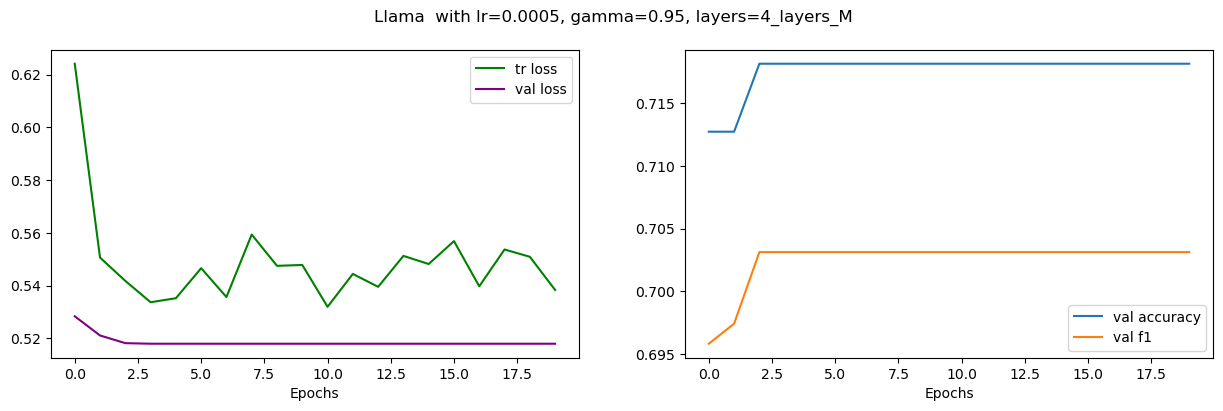

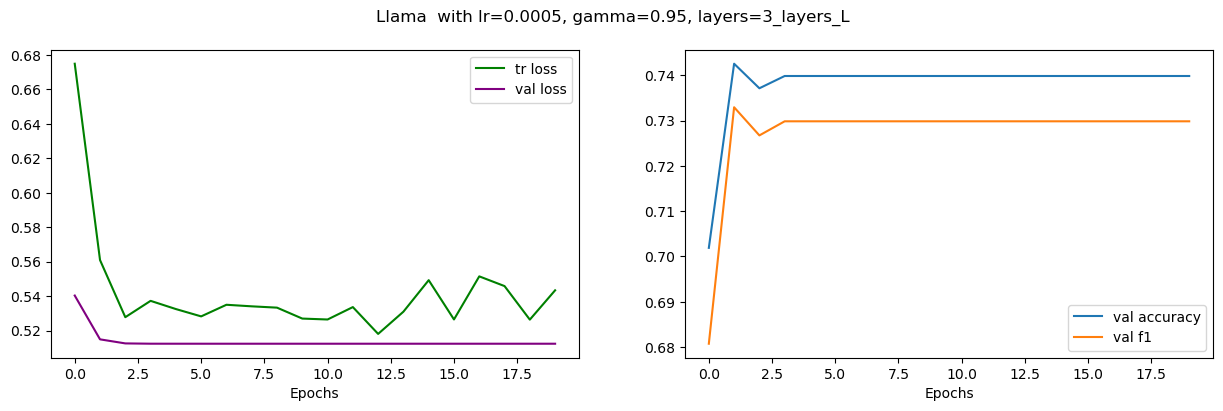

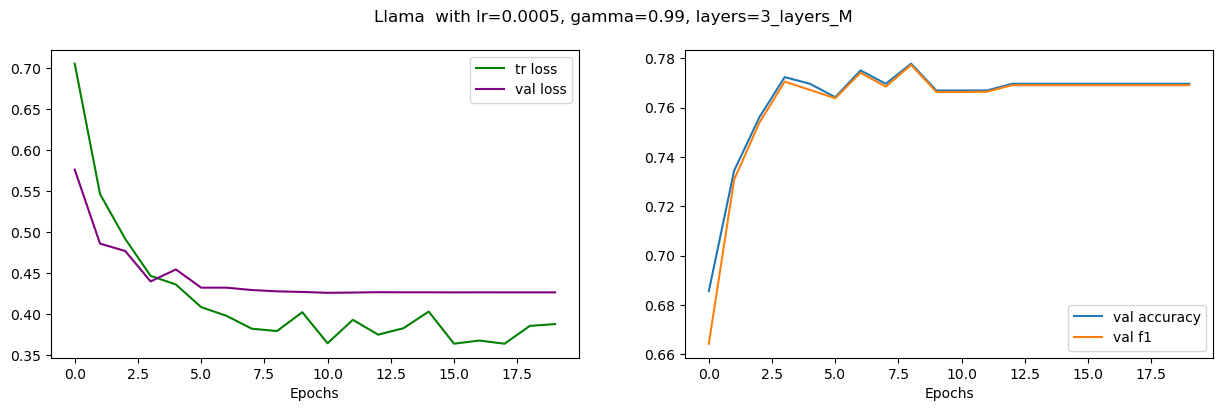

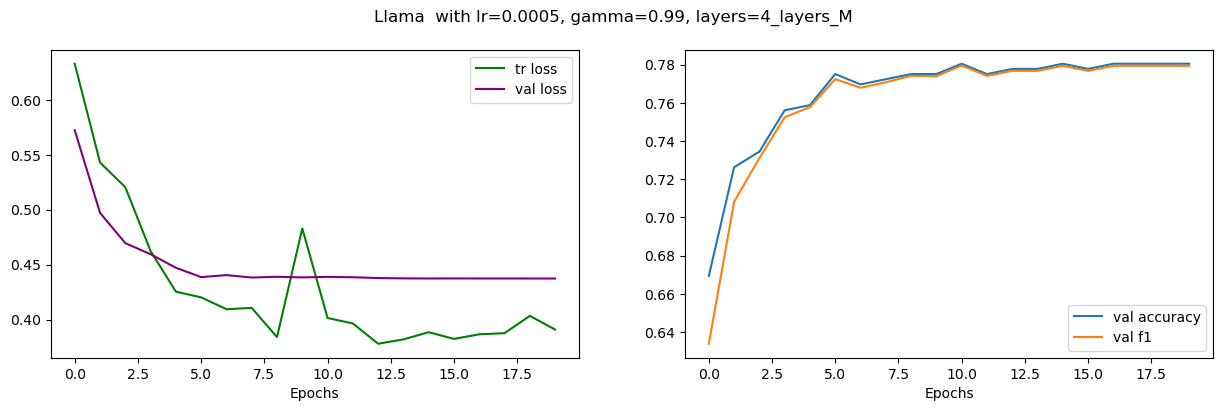

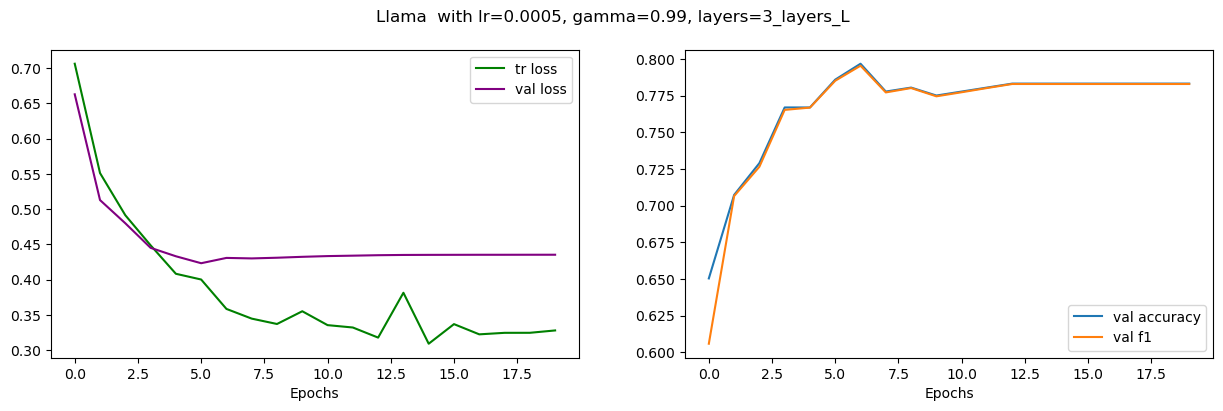

In [56]:
save_folder_pth = './checkpoints_llama_subtaskA/1_5_2023-1.16/' # Grid search run to analyze


best_f1_list = []

for lr in lr_list:
    for gamma in gamma_list:
        for layers_config in layers_config_list: 

            # Model path subfolder
            model_folder_str = 'lr{}_gamma{}_layers_{}'.format(lr, gamma, layers_config['name'])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'Llama  with lr={}, gamma={}, layers={}'.format(lr, gamma, layers_config['name'])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'llama_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [57]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

Llama  with lr=1e-05, gamma=0.95, layers=3_layers_M at epoch 2, F1: 0.6454
Llama  with lr=1e-05, gamma=0.95, layers=4_layers_M at epoch 1, F1: 0.6374
Llama  with lr=1e-05, gamma=0.95, layers=4_layers_L at epoch 0, F1: 0.6343
Llama  with lr=1e-05, gamma=0.99, layers=3_layers_M at epoch 9, F1: 0.7411
Llama  with lr=1e-05, gamma=0.99, layers=4_layers_M at epoch 4, F1: 0.6689
Llama  with lr=1e-05, gamma=0.99, layers=4_layers_L at epoch 10, F1: 0.6979
Llama  with lr=5e-05, gamma=0.95, layers=3_layers_M at epoch 1, F1: 0.7067
Llama  with lr=5e-05, gamma=0.95, layers=4_layers_M at epoch 0, F1: 0.6384
Llama  with lr=5e-05, gamma=0.95, layers=4_layers_L at epoch 1, F1: 0.6967
Llama  with lr=5e-05, gamma=0.99, layers=3_layers_M at epoch 4, F1: 0.7707
Llama  with lr=5e-05, gamma=0.99, layers=4_layers_M at epoch 8, F1: 0.7553
Llama  with lr=5e-05, gamma=0.99, layers=4_layers_L at epoch 9, F1: 0.7709
Llama  with lr=0.0001, gamma=0.95, layers=3_layers_M at epoch 2, F1: 0.7450
Llama  with lr=0.0001, 

## Choose and predict on test with best model

Best model is: Llama embed classifier with lr=0.0005, gamma=0.99, layers=4_layers_L at epoch 6, F1: 0.7954


In [60]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [78]:
final_model_pth = './checkpoints_llama_subtaskA/1_5_2023-1.16/lr0.0005_gamma0.99_layers_4_layers_L/llama_clf_6.pt'

layers_config = {'layers': [8192, 1024, 64], 'dropout':[0.5, 0.3, 0.1], 'name': '4_layers_L'}

llama_embeds_clf = LllamaEmbedsClf(hidden_layers_dim=layers_config['layers'], layers_dropout=layers_config['dropout'])

llama_embeds_clf.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

llama_embeds_clf.to(device)

# Prediction on test
test_preds = test_clf(llama_embeds_clf, test_dataloader, device)

In [79]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 

Generate result CSV

In [81]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_llama_submission.csv', index=False)

**RESULTS FROM KAGGLE:**

On the 30% available hidden test set it scores **0.80755**  F1 macro averaged